In [2]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
import os

## Model Architecture

In [4]:
layer1out = 512
layer2out = 256
layer3out = 128
layer4out = 64
z_size = 100
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.conv1 = nn.ConvTranspose2d(z_size,layer1out,4,1,0,bias=False)
    self.conv2 = nn.ConvTranspose2d(layer1out,layer2out,4,2,1,bias=False)
    self.conv3 = nn.ConvTranspose2d(layer2out,layer3out,4,2,1,bias=False)
    self.conv4 = nn.ConvTranspose2d(layer3out,layer4out,4,2,1,bias=False)
    self.conv5 = nn.ConvTranspose2d(layer4out,1,4,2,1,bias=False)
    self.leaky = nn.LeakyReLU()
    self.bn1 = nn.BatchNorm2d(layer1out)
    self.bn2 = nn.BatchNorm2d(layer2out)
    self.bn3 = nn.BatchNorm2d(layer3out)
    self.bn4 = nn.BatchNorm2d(layer4out)
    self.tanh = nn.Tanh()

  def forward(self, x):
    x = self.leaky(self.bn1(self.conv1(x)))
    x = self.leaky(self.bn2(self.conv2(x)))
    x = self.leaky(self.bn3(self.conv3(x)))
    x = self.leaky(self.bn4(self.conv4(x)))
    x = self.tanh(self.conv5(x))
    return x

In [5]:
layer0out = 64
layer1out = 128
layer2out = 256
layer3out = 512

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.conv0 = nn.Conv2d(1,layer0out,4,2,1,bias=False)
    self.conv1 = nn.Conv2d(layer0out,layer1out,4,2,1,bias=False)
    self.conv2 = nn.Conv2d(layer1out,layer2out,4,2,1,bias=False)
    self.conv3 = nn.Conv2d(layer2out,layer3out,4,2,1,bias=False)
    self.conv4 = nn.Conv2d(layer3out,1,4,1,0,bias=False)
    self.bn0 = nn.BatchNorm2d(layer0out)
    self.bn1 = nn.BatchNorm2d(layer1out)
    self.bn2 = nn.BatchNorm2d(layer2out)
    self.bn3 = nn.BatchNorm2d(layer3out)

  def forward(self, x):
    x = F.leaky_relu(self.conv0(x))
    x = F.leaky_relu(self.bn1(self.conv1(x)))
    x = F.leaky_relu(self.bn2(self.conv2(x)))
    x = F.leaky_relu(self.bn3(self.conv3(x)))
    x = torch.sigmoid(self.conv4(x))
    return x

In [4]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data,0.0,0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data,0)

In [ ]:
torch.backends.cudnn.enabled = False
d = Discriminator()
g = Generator()
d.apply(weights_init)
g.cuda()
d.cuda()

In [16]:
"""from google.colab import drive
drive.mount('/content/gdrive')
"""
FILE = './Images/'
size = 64

In [17]:
batch_size = 32
dataset = torchvision.datasets.ImageFolder(root=FILE,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Grayscale(),
                                    torchvision.transforms.Resize(size),
                                    torchvision.transforms.CenterCrop(size),
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)

device = torch.device('cuda:0')

In [9]:
lr1 = 0.0002
lr2 = 0.0002
crit = nn.BCELoss()

optd = torch.optim.Adam(d.parameters(),lr=lr1,betas=(0.5,0.999))
optg = torch.optim.Adam(g.parameters(),lr=lr2,betas=(0.5,0.999))


## Training

In [ ]:
iters=0
epochs = 500
checkpoint = 246
log_list =[]
for epoch in range(checkpoint, epochs):
    for i, data in enumerate(dataloader, 0):
    
        # Discriminator
        #    real
        d.zero_grad()
        inps = data[0].to(device)
        labels = torch.full((inps.shape[0],),random.uniform(0.9,1),device=device)

        output = d(inps).view(-1)
        loss_dis_real = crit(output,labels)
        loss_dis_real.backward()

        #    fake
        fake_inps = g(torch.randn(inps.shape[0],100,1,1,device=device))
        labels.fill_(0)

        output = d(fake_inps.detach()).view(-1)

        loss_dis_fake = crit(output,labels)
        loss_dis_fake.backward()

        loss_dis = loss_dis_real + loss_dis_fake

        optd.step()

        # Generator
        g.zero_grad()
        labels.fill_(1)
        output = d(fake_inps).view(-1)

        loss_gen = crit(output,labels)
        loss_gen.backward()

        optg.step()
        if i % 100 ==0:
            log_text='Epoch: ' + str(epoch) + '\tloss_dis:' + str(float(loss_dis)) + '\tloss_gen: ' + str(float(loss_gen))
            print(log_text)
            log_list.append(log_text)
            log_list.append('\n')
    
    if epoch % 20 == 0:
        f = open("log.txt",'w')
        f.writelines(log_list)
        log_list=[]
    sample_pics = g(torch.randn(10,100,1,1,device=device))
    for i,pic in enumerate(sample_pics):
        plt.imsave('e'+str(epoch)+'_'+str(i),pic.cpu().detach().numpy().reshape(64,64),cmap='gray')
    
f.close() 

Epoch: 368	loss_dis:0.18555298447608948	loss_gen: 4.816432476043701
Epoch: 368	loss_dis:0.3346171975135803	loss_gen: 5.669260025024414
Epoch: 368	loss_dis:0.3643634021282196	loss_gen: 6.127695560455322
Epoch: 368	loss_dis:0.2838551998138428	loss_gen: 5.2623090744018555
Epoch: 368	loss_dis:0.27271270751953125	loss_gen: 5.477044105529785
Epoch: 368	loss_dis:0.36946001648902893	loss_gen: 6.898317337036133
Epoch: 368	loss_dis:0.36804094910621643	loss_gen: 6.75289249420166
Epoch: 369	loss_dis:0.1039678305387497	loss_gen: 4.480154991149902
Epoch: 369	loss_dis:0.3639626204967499	loss_gen: 6.006103992462158
Epoch: 369	loss_dis:0.35258355736732483	loss_gen: 5.847054481506348
Epoch: 369	loss_dis:0.32254254817962646	loss_gen: 5.35646915435791
Epoch: 369	loss_dis:0.32654112577438354	loss_gen: 5.90870475769043
Epoch: 369	loss_dis:0.3587418496608734	loss_gen: 5.937780857086182
Epoch: 369	loss_dis:0.1789572387933731	loss_gen: 5.042380332946777
Epoch: 370	loss_dis:0.05646898224949837	loss_gen: 5.21745

In [268]:
torch.save(d,'discrim')
torch.save(g,'generat')

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Generating Results

In [7]:
d = torch.load('discrim', map_location='cpu')
g = torch.load('generat', map_location='cpu')

In [10]:
# 
d.zero_grad()
g.zero_grad()
generated = g(torch.randn(1000,100,1,1,device='cpu'))
out = d(generated).view(-1)
losses = []
for score in out:
    losses.append(crit(score, torch.full((1,),1,device='cpu')))

C:\Users\jarcilla\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


In [11]:
sorted_loss_inds = np.argsort(losses)

In [12]:
best_images = generated[sorted_loss_inds][:100]

From these results we see that there are a lot of well generated pictures such as the following.

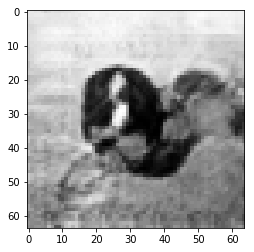

In [44]:
plt.imshow(best_images[7].detach().numpy().reshape(64,64),cmap='gray')

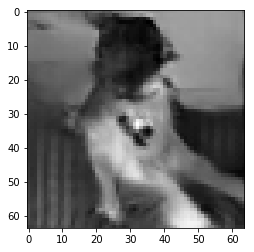

In [48]:
plt.imshow(best_images[11].detach().numpy().reshape(64,64),cmap='gray')

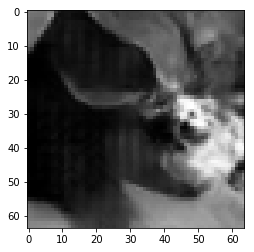

In [82]:
plt.imshow(best_images[4].detach().numpy().reshape(64,64),cmap='gray')

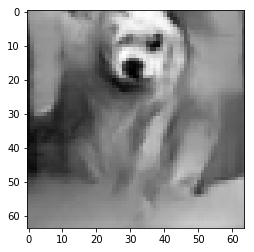

In [85]:
plt.imshow(best_images[58].detach().numpy().reshape(64,64),cmap='gray')

It seems the model has also undergone mode collapse as well with this recurring picture:

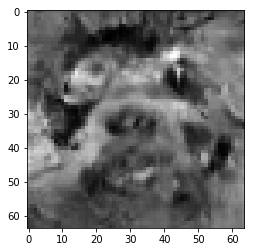

In [77]:
plt.imshow(best_images[12].detach().numpy().reshape(64,64),cmap='gray')

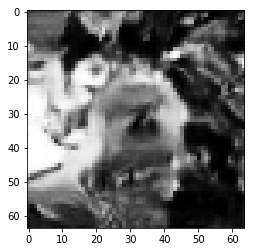

In [58]:
plt.imshow(best_images[20].detach().numpy().reshape(64,64),cmap='gray')

Looking past the nightmare inducing features we're able to see that the recurring picture has the same facial structures however with bits and pieces of different dogs implanted. Note how the first dog's right eye is similar to that of a Maltese dog ![alt text](https://www.petmd.com/sites/default/files/breedopedia/maltese3.jpg) 

while the second seems to be a different dog entirely.

Another type of image generated include incomplete dogs:

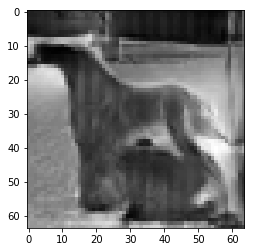

In [86]:
plt.imshow(best_images[0].detach().numpy().reshape(64,64),cmap='gray')

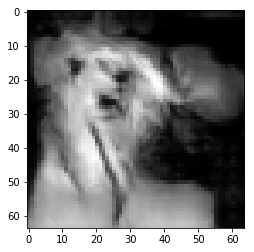

In [89]:
plt.imshow(best_images[1].detach().numpy().reshape(64,64),cmap='gray')

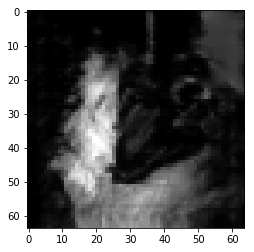

In [92]:
plt.imshow(best_images[2].detach().numpy().reshape(64,64),cmap='gray')

Further development of the model requires higher care and a more watchful eye over the outputs to prevent mode collapse. THe incompleteness of some of the dogs can be fixed with a longer run time as the losses converge further.